In [1]:
"""
新人培训--CSDN有监督二分类建模
"""

'\n\xe6\x96\xb0\xe4\xba\xba\xe5\x9f\xb9\xe8\xae\xad--CSDN\xe6\x9c\x89\xe7\x9b\x91\xe7\x9d\xa3\xe4\xba\x8c\xe5\x88\x86\xe7\xb1\xbb\xe5\xbb\xba\xe6\xa8\xa1\n'

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', 300)

import datetime
import numpy as np
from collections import Counter
import time
import json
from derive_package.ua_parser import user_agent_parser

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from pyspark.sql.types import *
from pyspark.sql import functions

conf = SparkConf().setMaster("yarn-client").setAppName("fresh train csdn")
conf.set("spark.executor.instances", 30)
conf.set("spark.executor.memory", "5g")
conf.set("spark.executor.cores","1")
conf.set("spark.driver.memory", "8g")
conf.set("spark.files", "derive_package.tar.gz")  # 临时上传文件给spark任务

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext

In [217]:
# 加载函数集
%run functions.ipynb

## 1.数据预处理

In [122]:
df = spark.read.parquet("/data/lishuai/csdn_supervised_data/df_rawlog").persist(StorageLevel.MEMORY_AND_DISK)
df.count()

4195696

In [123]:
df.columns

['answers_count',
 'app_version',
 'bbs_title',
 'best_answer_time',
 'blog_title',
 'bury',
 'category',
 'checkout_status',
 'checkout_user_id',
 'comments_count',
 'created_time',
 'device_model',
 'digg',
 'dup_resource_id',
 'email',
 'event_type',
 'focus_count',
 'forum_id',
 'gps',
 'id',
 'ip',
 'is_recommend',
 'is_tech',
 'last_edit_time',
 'last_post_id',
 'login_result',
 'mobile',
 'node-uuid',
 'os_type',
 'os_version',
 'phone_name',
 'point',
 'posts_count',
 'question_id',
 'question_title',
 'register_type',
 'resource_category',
 'resource_duplicate_status',
 'resource_id',
 'resource_owner',
 'resource_score',
 'resource_title',
 'resource_type',
 'resource_user_type',
 'status',
 'summary',
 'time_stamp',
 'topic_detail_id',
 'uid',
 'updated_time',
 'user_agent',
 'user_id',
 'user_name',
 'view_count',
 'visits_count']

In [124]:
df.limit(5).toPandas()

,answers_count,app_version,bbs_title,best_answer_time,blog_title,bury,category,checkout_status,checkout_user_id,comments_count,created_time,device_model,digg,dup_resource_id,email,event_type,focus_count,forum_id,gps,id,ip,is_recommend,is_tech,last_edit_time,last_post_id,login_result,mobile,node-uuid,os_type,os_version,phone_name,point,posts_count,question_id,question_title,register_type,resource_category,resource_duplicate_status,resource_id,resource_owner,resource_score,resource_title,resource_type,resource_user_type,status,summary,time_stamp,topic_detail_id,uid,updated_time,user_agent,user_id,user_name,view_count,visits_count
0,None,,None,None,None,None,None,None,None,None,None,smartphone,None,None,None,login,None,None,,None,111.16.230.39,None,None,None,None,success,None,None,Android,8.1.0,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 17:35:03,None,3e2ef34fb0cc0ada00eea28fe24dc98c,None,Mozilla/5.0 (Linux; U; Android 8.1.0; zh-cn; M...,73313023,qq_42804513,None,None
1,None,None,None,None,quartz从入门到实战,None,,None,None,None,None,pc,None,None,None,create_blog,None,None,,&amp;lt;!-- 引...,222.64.95.232,None,None,None,None,None,None,None,Windows 7,NT 6.1,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,无状态,简介：Quartz是OpenSymphony开源组织在Job scheduling领域又一个...,2018-07-26 17:02:39,None,80ad4181658db8de97f6587efe74319a,None,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,5549583,uniqueweimeijun,None,None
2,None,,None,None,None,None,None,None,None,None,None,pc,None,None,None,login,None,None,,None,123.125.37.227,None,None,None,None,success,None,None,Windows 7,NT 6.1,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 17:03:13,None,1cf2a773c66994359728f9c06a1ff8b7,None,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,16615754,yefengxuelang,None,None
3,None,,None,None,None,None,None,None,None,None,None,pc,None,None,None,login,None,None,,None,113.109.129.44,None,None,None,None,success,None,None,Windows 10,NT 10.0,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 21:02:40,None,6d50664f561d700bc798ee63ae8a3e96,None,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,67354932,weixin_38184535,None,None
4,None,None,None,None,None,None,None,None,None,None,None,pc,None,None,None,download_resource,None,None,,None,112.8.247.246,None,None,None,None,None,None,None,Windows 10,NT 10.0,None,None,None,None,None,None,其它,None,10373019,qq_32261191,2.0,防火墙系统实验,zip,VIP,None,None,2018-07-26 18:58:06,None,0b762d2ca4c225c662469bde0b98bb99,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,70310090,musanxu,None,None


## 2.观察数据

In [31]:
# 缺失值
df_miss_rate(df)

,col,miss_cnt,miss_ratio
0,uid,0,0.000000
1,time_stamp,0,0.000000
2,event_type,94,0.000022
3,user_name,94,0.000022
4,ip,94,0.000022
5,user_agent,94,0.000022
6,user_id,94,0.000022
7,os_version,94,0.000022
8,gps,94,0.000022
9,device_model,94,0.000022


In [32]:
# 取值数
df_col_value_distinct_cnt(df)

,col,value_cnt
0,visits_count,2
1,node-uuid,2
2,phone_name,2
3,comments_count,2
4,focus_count,2
5,answers_count,2
6,checkout_status,3
7,resource_duplicate_status,3
8,posts_count,3
9,login_result,4


In [33]:
# 事件数最多的取值  
for col in df.columns:
    df_col_value_distribute(df, col)

,answers_count,count
0,None,4194518
1,0,1178


,app_version,count
0,,2433185
1,None,1758986
2,2.0.1,2273
3,2.0.5,984
4,3.2.3,105


,bbs_title,count
0,None,4190849
1,百日攻坚行动,76
2,北京交警提示,25
3,交管动态,7
4,下周出行提示,6


,best_answer_time,count
0,None,4194518
1,2018-07-16 14:33:27,1
2,2018-07-23 11:30:56,1
3,2018-07-23 15:12:40,1
4,2018-07-31 05:57:27,1


,blog_title,count
0,None,3900011
1,,268
2,学习日志,159
3,正则表达式,108
4,test,101


,bury,count
0,None,4190849
1,0,4843
2,50,3
3,78,1


,category,count
0,None,3895166
1,,300326
2,无状态,126
3,链接审核,60
4,未审核,3


,checkout_status,count
0,None,4190849
1,未结帖,4843
2,0,4


,checkout_user_id,count
0,None,4190849
1,,4843
2,403371753,1
3,403363300,1
4,403367283,1


,comments_count,count
0,None,4189169
1,0,6527


,created_time,count
0,None,4190849
1,,3
2,2018-07-26 14:29:26,2
3,2018-07-27 10:46:48,2
4,2018-07-30 09:53:15,2


,device_model,count
0,pc,3946156
1,smartphone,233606
2,,9325
3,UNKNOWN,4868
4,misc,1482


,digg,count
0,None,4190849
1,0,4843
2,,1
3,2018-07-24 23:24:57,1
4,2018-07-23 11:21:37,1


,dup_resource_id,count
0,None,4058507
1,,42392
2,d41d8cd98f00b204e9800998ecf8427e,226
3,5c4e6df0f8be3935f78ea6fbcd1aee8c,70
4,d06d378222932e1c9eb36ee6e10f94f4,56


,email,count
0,None,4064720
1,,115562
2,lixin2015y@163.com,2
3,hz798795409@qq.com,2
4,446069867@qq.com,1


,event_type,count
0,login,2305734
1,download_resource,1314644
2,create_blog,295685
3,upload_resource,137189
4,register,130976


,focus_count,count
0,None,4194518
1,,1178


,forum_id,count
0,None,4190849
1,111,310
2,214,306
3,499,292
4,220,210


,gps,count
0,,4106226
1,"37.09024,-95.712891",2546
2,"22.396428,114.10949699999999",1415
3,"23.69781,120.96051500000002",1345
4,"0,0",1219


,id,count
0,None,3888639
1,,5443
2,public static void main(String[] args) {,309
3,&amp;lt;head&amp;gt;,278
4,79309421,206


,ip,count
0,39.108.180.156,7174
1,221.226.125.133,7151
2,183.222.102.82,4631
3,183.222.102.81,4499
4,61.135.169.80,3683


,is_recommend,count
0,None,4190849
1,false,4843
2,2018-07-26 19:51:57,1
3,2018-07-23 11:21:37,1
4,0,1


,is_tech,count
0,None,4190849
1,true,3577
2,false,1269
3,2018-07-12 14:46:51,1


,last_edit_time,count
0,None,4189169
1,2018-07-14 11:14:05,3
2,2018-07-18 17:05:19,2
3,2018-07-12 10:06:57,2
4,2018-07-26 17:55:51,2


,last_post_id,count
0,None,4190849
1,403346552,1
2,403367402,1
3,403368801,1
4,403362163,1


,login_result,count
0,None,1889962
1,success,1807680
2,failed,498044
3,,10


,mobile,count
0,None,4064720
1,1702447XXXX,43
2,1786311XXXX,27
3,1781687XXXX,22
4,1785411XXXX,21


,node-uuid,count
0,None,4195695
1,~,1


,os_type,count
0,Windows 10,1990701
1,Windows 7,1455281
2,Mac OSX,257689
3,Android,177921
4,Windows 8.1,90323


,os_version,count
0,NT 10.0,1990701
1,NT 6.1,1455281
2,,106391
3,NT 6.3,90323
4,10.13.5,57723


,phone_name,count
0,,2436710
1,None,1758986


,point,count
0,NaN,4190849
1,50.0,2853
2,0.0,1041
3,100.0,555
4,200.0,185


,posts_count,count
0,None,4190849
1,0,4846
2,392413962,1


,question_id,count
0,None,4190347
1,692285,107
2,693507,40
3,695312,25
4,695268,25


,question_title,count
0,None,4194518
1,《视觉SLAM十四讲》第5讲PCL的以命令行编译的问题 ？,2
2,linux bash脚本大神看看哪错了《求代码》,2
3,CSDN博客发布文章时 如何控制上传图片的方向,2
4,大数据运行在内存中产生的中间数据一般有多大？,2


,register_type,count
0,None,4064720
1,weixin,58255
2,qq,57120
3,csdn,15414
4,sinat,187


,resource_category,count
0,None,2743863
1,其它,204560
2,Java,180347
3,,94800
4,专业指导,85436


,resource_duplicate_status,count
0,None,4058507
1,重复资源,94797
2,新资源,42392


,resource_id,count
0,None,2743863
1,,94800
2,10399046,881
3,10481341,663
4,8577653,560


,resource_owner,count
0,None,2881052
1,u011433684,6570
2,towangjindian,3395
3,laoge,2574
4,niehanmin,2240


,resource_score,count
0,NaN,2838702
1,3.0,523055
2,5.0,386129
3,2.0,114394
4,10.0,93471


,resource_title,count
0,None,2743863
1,,94819
2,Microsoft Visual C++ 14.0,1082
3,Xshell6 中文版（不限时）,636
4,《算法导论 第三版 》中文版 高清完整PDF版,560


,resource_type,count
0,None,2743863
1,zip,333778
2,rar,328848
3,pdf,218061
4,application/x-rar,104304


,resource_user_type,count
0,None,2881052
1,VIP,717305
2,Mormal,597297
3,,22
4,2004v2004,4


,status,count
0,None,3888639
1,无状态,230241
2,链接审核,65209
3,true,5349
4,未审核,4843


,summary,count
0,None,3895166
1,,14399
2,欢迎使用Markdown编辑器写博客本Markdown编辑器使用StackEdit修改而来，...,419
3,,253
4,1,167


,time_stamp,count
0,,97
1,2018-07-12 08:54:44,20
2,2018-07-24 09:53:39,20
3,2018-07-12 09:00:19,19
4,2018-07-25 15:48:53,19


,topic_detail_id,count
0,None,4190849
1,,4
2,392411079,1
3,392419608,1
4,392409568,1


,uid,count
0,6f93629664f3dee33a43b72976c9bc12,2
1,3bc97c3e26c6ec00c2fb77b1217ebe2d,1
2,ae182e8bf0168fcb84838095437837a3,1
3,a925fb9deca2e2b6d606a6039c12273b,1
4,2c3e64dc2362e26a9a2f2e8d1e6c0cb6,1


,updated_time,count
0,None,4184322
1,0,3
2,2018-07-14 11:14:05,3
3,2018-07-27 11:42:08,2
4,2018-07-25 14:39:35,2


,user_agent,count
0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,256923
1,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,232213
2,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,215360
3,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,154489
4,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,144818


,user_id,count
0,,65396
1,67644719,7177
2,10880704,1453
3,72584614,997
4,73216713,892


,user_name,count
0,,65396
1,weixin_38450840,7178
2,go879546213,1453
3,caozhy,1080
4,lostvip,997


,view_count,count
0,None,4190849
1,0,4843
2,392421963,1
3,392419520,1
4,true,1


,visits_count,count
0,None,4194518
1,0,1178


## 3.字段衍生

In [125]:
# 时间戳衍生出秒数
def udf_ts(time_format="%Y-%m-%d %H:%M:%S"):
    def f(x):
        try:
            return time.mktime(datetime.datetime.strptime(x, time_format).timetuple())
        except:
            return -1.0
    return functions.udf(f, DoubleType())

df = df.withColumn("ts_mktime", udf_ts()("time_stamp"))
df = df_derive(df, "ip", derive_ip, **{"path": "derive_package/ip/ipseeker.dat"}) # ip衍生出城市和运营商
df = df_derive(df, "ip", derive_ip_prefix) # ip衍生前缀
df = df_derive(df, "user_agent", derive_ua) # ua衍生
df.limit(5).toPandas()

,answers_count,app_version,bbs_title,best_answer_time,blog_title,bury,category,checkout_status,checkout_user_id,comments_count,created_time,device_model,digg,dup_resource_id,email,event_type,focus_count,forum_id,gps,id,ip,is_recommend,is_tech,last_edit_time,last_post_id,login_result,mobile,node-uuid,os_type,os_version,phone_name,point,posts_count,question_id,question_title,register_type,resource_category,resource_duplicate_status,resource_id,resource_owner,resource_score,resource_title,resource_type,resource_user_type,status,summary,time_stamp,topic_detail_id,uid,updated_time,user_agent,user_id,user_name,view_count,visits_count,ts_mktime
0,None,,None,None,None,None,None,None,None,None,None,smartphone,None,None,None,login,None,None,,None,111.16.230.39,None,None,None,None,success,None,None,Android,8.1.0,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 17:35:03,None,3e2ef34fb0cc0ada00eea28fe24dc98c,None,Mozilla/5.0 (Linux; U; Android 8.1.0; zh-cn; M...,73313023,qq_42804513,None,None,1.532598e+09
1,None,None,None,None,quartz从入门到实战,None,,None,None,None,None,pc,None,None,None,create_blog,None,None,,&amp;lt;!-- 引...,222.64.95.232,None,None,None,None,None,None,None,Windows 7,NT 6.1,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,无状态,简介：Quartz是OpenSymphony开源组织在Job scheduling领域又一个...,2018-07-26 17:02:39,None,80ad4181658db8de97f6587efe74319a,None,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,5549583,uniqueweimeijun,None,None,1.532596e+09
2,None,,None,None,None,None,None,None,None,None,None,pc,None,None,None,login,None,None,,None,123.125.37.227,None,None,None,None,success,None,None,Windows 7,NT 6.1,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 17:03:13,None,1cf2a773c66994359728f9c06a1ff8b7,None,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,16615754,yefengxuelang,None,None,1.532596e+09
3,None,,None,None,None,None,None,None,None,None,None,pc,None,None,None,login,None,None,,None,113.109.129.44,None,None,None,None,success,None,None,Windows 10,NT 10.0,,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,2018-07-26 21:02:40,None,6d50664f561d700bc798ee63ae8a3e96,None,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,67354932,weixin_38184535,None,None,1.532610e+09
4,None,None,None,None,None,None,None,None,None,None,None,pc,None,None,None,download_resource,None,None,,None,112.8.247.246,None,None,None,None,None,None,None,Windows 10,NT 10.0,None,None,None,None,None,None,其它,None,10373019,qq_32261191,2.0,防火墙系统实验,zip,VIP,None,None,2018-07-26 18:58:06,None,0b762d2ca4c225c662469bde0b98bb99,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,70310090,musanxu,None,None,1.532603e+09


In [129]:
df.persist()

DataFrame[answers_count: string, app_version: string, bbs_title: string, best_answer_time: string, blog_title: string, bury: string, category: string, checkout_status: string, checkout_user_id: string, comments_count: string, created_time: string, device_model: string, digg: string, dup_resource_id: string, email: string, event_type: string, focus_count: string, forum_id: string, gps: string, id: string, ip: string, is_recommend: string, is_tech: string, last_edit_time: string, last_post_id: string, login_result: string, mobile: string, node-uuid: string, os_type: string, os_version: string, phone_name: string, point: int, posts_count: string, question_id: string, question_title: string, register_type: string, resource_category: string, resource_duplicate_status: string, resource_id: string, resource_owner: string, resource_score: double, resource_title: string, resource_type: string, resource_user_type: string, status: string, summary: string, time_stamp: string, topic_detail_id: stri

In [130]:
df.dtypes

[('answers_count', 'string'),
 ('app_version', 'string'),
 ('bbs_title', 'string'),
 ('best_answer_time', 'string'),
 ('blog_title', 'string'),
 ('bury', 'string'),
 ('category', 'string'),
 ('checkout_status', 'string'),
 ('checkout_user_id', 'string'),
 ('comments_count', 'string'),
 ('created_time', 'string'),
 ('device_model', 'string'),
 ('digg', 'string'),
 ('dup_resource_id', 'string'),
 ('email', 'string'),
 ('event_type', 'string'),
 ('focus_count', 'string'),
 ('forum_id', 'string'),
 ('gps', 'string'),
 ('id', 'string'),
 ('ip', 'string'),
 ('is_recommend', 'string'),
 ('is_tech', 'string'),
 ('last_edit_time', 'string'),
 ('last_post_id', 'string'),
 ('login_result', 'string'),
 ('mobile', 'string'),
 ('node-uuid', 'string'),
 ('os_type', 'string'),
 ('os_version', 'string'),
 ('phone_name', 'string'),
 ('point', 'int'),
 ('posts_count', 'string'),
 ('question_id', 'string'),
 ('question_title', 'string'),
 ('register_type', 'string'),
 ('resource_category', 'string'),
 ('r

## 4.特征提取

In [131]:
rdd = df.rdd.map(list)
schema = df.columns

In [154]:
# 特征函数
class ClientFeatures():
    
    def __init__(self, **args):
        pass

    def get_features(self, events, schema, **args):
        """
        特征提取的主函数
        """
        ret = {}
        # 类别统计特征
        cat_cols =  [
             'app_version',
             'bury',
             'category',
             'checkout_status',
             'device_model',
             'event_type',
             'is_recommend',
             'is_tech',
             'login_result',
             'os_type',
             'os_version',
             'register_type',
             'resource_category',
             'resource_type',
             'resource_user_type',
             'status',
             'ip_carrier',
             'ip_city',
             'ip_prefix_20',
             'ip_prefix_22',
             'ip_prefix_24',
             'user_agent_device_family',
             'user_agent_os_family',
             'user_agent_ua_family',
        ]
        
        # 类别字段的统计特征
        for col in cat_cols:
            features = category_stats(events, schema, **{"col": col})
            ret.update(features)    
            
        # todo 思考：set_feature里每个特征有多个取值，如何处理？
        for col in cat_cols:
            features = cat_set_feature(events, schema, **{"col": col})
            ret.update(features)   
            
        # todo 思考：mode_feature里每个特征都是类别特征，如何处理？
        for col in cat_cols:
            features = cat_mode_feature(events, schema, **{"col": col})
            ret.update(features)   
            
        # 时间差统计特征
        features = timedelta_stat(events, schema, col="ts_mktime")
        ret.update(features)
        
        return ret
    
client_features = ClientFeatures()

In [155]:
# 测试 client_features 是否有bug
tmp_events = rdd.take(10)
tmp_fea = client_features.get_features(tmp_events, schema)
print len(tmp_fea)
feature_schema = sorted(tmp_fea.keys())
tmp_fea

520


{'app_version_catstat_Avg': -100000000.0,
 'app_version_catstat_Cnt': -1,
 'app_version_catstat_Cv': -100000000.0,
 'app_version_catstat_Entropy': -1,
 'app_version_catstat_Gini': -1,
 'app_version_catstat_Iqr': -100000000.0,
 'app_version_catstat_Kur': -100000000.0,
 'app_version_catstat_Max': -100000000.0,
 'app_version_catstat_MeanAbsDev': -100000000.0,
 'app_version_catstat_Min': -100000000.0,
 'app_version_catstat_Ptp': -100000000.0,
 'app_version_catstat_Quar10': -100000000.0,
 'app_version_catstat_Quar25': -100000000.0,
 'app_version_catstat_Quar50': -100000000.0,
 'app_version_catstat_Quar75': -100000000.0,
 'app_version_catstat_Quar90': -100000000.0,
 'app_version_catstat_Skew': -100000000.0,
 'app_version_catstat_Std': -100000000.0,
 'app_version_catstat_Sum': -100000000.0,
 'bury_catstat_Avg': -100000000.0,
 'bury_catstat_Cnt': -1,
 'bury_catstat_Cv': -100000000.0,
 'bury_catstat_Entropy': -1,
 'bury_catstat_Gini': -1,
 'bury_catstat_Iqr': -100000000.0,
 'bury_catstat_Kur': 

In [156]:
# 把每个人的事件聚合起来 并按时间排序
idx_user = schema.index('user_name')
idx_time = schema.index('time_stamp')
rdd_group = rdd.map(lambda x: (x[idx_user], x)
                          ).groupByKey().map(lambda x: (x[0], sorted(x[1], key=lambda y: y[idx_time])))

In [157]:
# 批量计算特征
# 注意：这一步计算会比较耗时，可以进入yarn的管理页面，点击你的任务的ApplicationMaster，查看spark任务的执行进度
# 如何进入yarn页面，请询问你的导师或模型组其他同学
rdd_feature = rdd_group.map(lambda x: (x[0], client_features.get_features(x[1], schema))).persist()
rdd_feature.count()

753203

In [158]:
# 调试技巧：如果发现spark任务报错，可以通过 filter(debug) 的方式找出出错的数据，在debug里加入try except 即可
# def debug(x):
#     try:
#         client_features.get_features(x[1], schema)
#         return False
#     except:
#         return True

# tmp = rdd_group.filter(debug).take(1)[0]
# tmp

In [161]:
# 保存特征矩阵 以json格式 

def to_json(x):
    x[1].update({"user_name": x[0]})
    return x[1]

path = "/data/fresh_train/project_csdn/demo_feature" # todo 修改成你的路径
rdd_feature.map(lambda x: to_json(x)).map(json.dumps).saveAsTextFile(path)

## 5.生成特征矩阵

In [172]:
path = "/data/fresh_train/project_csdn/demo_feature" # todo 修改成你的路径
rdd_feature = sc.textFile(path).map(json.loads)
rdd_feature.take(1)

[{u'app_version_catstat_Avg': -100000000.0,
  u'app_version_catstat_Cnt': -1,
  u'app_version_catstat_Cv': -100000000.0,
  u'app_version_catstat_Entropy': -1,
  u'app_version_catstat_Gini': -1,
  u'app_version_catstat_Iqr': -100000000.0,
  u'app_version_catstat_Kur': -100000000.0,
  u'app_version_catstat_Max': -100000000.0,
  u'app_version_catstat_MeanAbsDev': -100000000.0,
  u'app_version_catstat_Min': -100000000.0,
  u'app_version_catstat_Ptp': -100000000.0,
  u'app_version_catstat_Quar10': -100000000.0,
  u'app_version_catstat_Quar25': -100000000.0,
  u'app_version_catstat_Quar50': -100000000.0,
  u'app_version_catstat_Quar75': -100000000.0,
  u'app_version_catstat_Quar90': -100000000.0,
  u'app_version_catstat_Skew': -100000000.0,
  u'app_version_catstat_Std': -100000000.0,
  u'app_version_catstat_Sum': -100000000.0,
  u'bury_catstat_Avg': -100000000.0,
  u'bury_catstat_Cnt': -1,
  u'bury_catstat_Cv': -100000000.0,
  u'bury_catstat_Entropy': -1,
  u'bury_catstat_Gini': -1,
  u'bury

In [173]:
rdd_feature.persist()
rdd_feature.count()

PythonRDD[1114] at RDD at PythonRDD.scala:48

753203

In [174]:
df_train_user = spark.read.parquet("/data/fresh_train/project_csdn/train_set_label")
print df_train_user.count()
df_train_user.show(5)

602561
+---------------+-----+
|      user_name|label|
+---------------+-----+
|     pipinet123| good|
|weixin_42797071| good|
|      s10784967| good|
|weixin_42832114| good|
|  feiying111222| good|
+---------------+-----+
only showing top 5 rows



In [175]:
df_train_user = df_train_user.withColumn("label", functions.udf(lambda x: 0 if x=="good" else 1)("label"))
df_train_user.show(5)

+---------------+-----+
|      user_name|label|
+---------------+-----+
|     pipinet123|    0|
|weixin_42797071|    0|
|      s10784967|    0|
|weixin_42832114|    0|
|  feiying111222|    0|
+---------------+-----+
only showing top 5 rows



In [176]:
df_test_user = spark.read.parquet("/data/fresh_train/project_csdn/test_set_label")
print df_test_user.count()
df_test_user.show(5)

150640
+---------------+-----+
|      user_name|label|
+---------------+-----+
|   zhenxingyang| good|
|weixin_42519520| good|
|    qq_42770439| good|
|         mnmnwq| good|
|    Wind_waving| good|
+---------------+-----+
only showing top 5 rows



In [177]:
df_test_user = df_test_user.withColumn("label", functions.udf(lambda x: 0 if x=="good" else 1)("label"))
df_test_user.show(5)

+---------------+-----+
|      user_name|label|
+---------------+-----+
|   zhenxingyang|    0|
|weixin_42519520|    0|
|    qq_42770439|    0|
|         mnmnwq|    0|
|    Wind_waving|    0|
+---------------+-----+
only showing top 5 rows



#### 生成数值型特征矩阵

In [178]:
def get_num_feature(x):
    ret = dict()
    for k,v in x.items():
        if "mode_feature" in k or "set_feature" in k:
            pass
        else:
            ret[k] = v
    return ret


In [179]:
df_num_feature = spark.createDataFrame(rdd_feature.map(get_num_feature))

In [180]:
df_num_feature_train = df_train_user.join(df_num_feature, on="user_name", how="inner")
df_num_feature_train.count() # 这个数值应该与 df_train_user.count() 一样

602561

In [181]:
pdf_num_feature_train = df_num_feature_train.toPandas() # 注意：如果driver memory太小，此处可能会OOM

In [182]:
df_num_feature_test = df_test_user.join(df_num_feature, on="user_name", how="inner")
df_num_feature_test.count() # 这个数值应该与 df_test_user.count() 一样

150640

In [183]:
pdf_num_feature_test = df_num_feature_test.toPandas() # 注意：如果driver memory太小，此处可能会OOM

#### 生成单个取值的类别特征矩阵

In [184]:
def get_mode_feature(x):
    ret = dict()
    for k,v in x.items():
        if "mode_feature" in k or k=="user_name":
            ret[k] = v
    return ret

In [185]:
df_mode_feature = spark.createDataFrame(rdd_feature.map(get_mode_feature))
df_mode_feature.limit(5).toPandas()

,mode_feature_app_version,mode_feature_bury,mode_feature_category,mode_feature_checkout_status,mode_feature_device_model,mode_feature_event_type,mode_feature_ip_carrier,mode_feature_ip_city,mode_feature_ip_prefix_20,mode_feature_ip_prefix_22,mode_feature_ip_prefix_24,mode_feature_is_recommend,mode_feature_is_tech,mode_feature_login_result,mode_feature_os_type,mode_feature_os_version,mode_feature_register_type,mode_feature_resource_category,mode_feature_resource_type,mode_feature_resource_user_type,mode_feature_status,mode_feature_user_agent_device_family,mode_feature_user_agent_os_family,mode_feature_user_agent_ua_family,user_name
0,,,,,smartphone,login,联通数据中心,天津,125.39.128.0,125.39.132.0,125.39.132.0,,,success,Android,8.0.0,,,,,,PRA-AL00,Android,QQ Browser Mobile,qq_17709237
1,,,,,pc,login,电信,南京,221.226.96.0,221.226.96.0,221.226.97.0,,,failed,Windows 7,NT 6.1,,,,,,Other,Windows,Chrome,weixin_39061184
2,,,,,pc,download_resource,北京科技大学,北京,123.124.144.0,123.124.144.0,123.124.147.0,,,success,Mac OSX,10.13.5,,Java,text/html,Mormal,,Other,Mac OS X,Chrome,qq_35590459
3,,,,,pc,login,电信,长沙,222.240.112.0,222.240.120.0,222.240.122.0,,,success,Mac OSX,10.12.6,,Redis,zip,Mormal,,Other,Mac OS X,Chrome,ippo520
4,,,,,pc,login,移动,杭州,223.93.144.0,223.93.144.0,223.93.147.0,,,success,Windows 7,NT 6.1,,Oracle,zip,Mormal,,Other,Windows,Chrome,p2424908886


In [186]:
df_mode_feature.persist()

DataFrame[mode_feature_app_version: string, mode_feature_bury: string, mode_feature_category: string, mode_feature_checkout_status: string, mode_feature_device_model: string, mode_feature_event_type: string, mode_feature_ip_carrier: string, mode_feature_ip_city: string, mode_feature_ip_prefix_20: string, mode_feature_ip_prefix_22: string, mode_feature_ip_prefix_24: string, mode_feature_is_recommend: string, mode_feature_is_tech: string, mode_feature_login_result: string, mode_feature_os_type: string, mode_feature_os_version: string, mode_feature_register_type: string, mode_feature_resource_category: string, mode_feature_resource_type: string, mode_feature_resource_user_type: string, mode_feature_status: string, mode_feature_user_agent_device_family: string, mode_feature_user_agent_os_family: string, mode_feature_user_agent_ua_family: string, user_name: string]

In [187]:
# 查看每个特征的取值个数，看看采用什么方式给特征做编码
for col in df_mode_feature.columns:
    print col, df_mode_feature.select(col).drop_duplicates().count()

mode_feature_app_version 10
mode_feature_bury 4
mode_feature_category 5
mode_feature_checkout_status 3
mode_feature_device_model 6
mode_feature_event_type 9
mode_feature_ip_carrier 3849
mode_feature_ip_city 577
mode_feature_ip_prefix_20 48449
mode_feature_ip_prefix_22 97532
mode_feature_ip_prefix_24 178587
mode_feature_is_recommend 5
mode_feature_is_tech 4
mode_feature_login_result 3
mode_feature_os_type 21
mode_feature_os_version 164
mode_feature_register_type 5
mode_feature_resource_category 143
mode_feature_resource_type 820
mode_feature_resource_user_type 7
mode_feature_status 17
mode_feature_user_agent_device_family 1847
mode_feature_user_agent_os_family 16
mode_feature_user_agent_ua_family 65
user_name 753203


In [188]:
# 只挑选一部分取值数量少的特征，生成编码字典
cols_select = [
    "mode_feature_app_version",
    "mode_feature_bury",
    "mode_feature_category",
    "mode_feature_checkout_status" ,
    "mode_feature_device_model" ,
    "mode_feature_event_type" ,
    "mode_feature_ip_city" ,
    "mode_feature_is_recommend" ,
    "mode_feature_is_tech" ,
    "mode_feature_login_result" ,
    "mode_feature_os_type" ,
    "mode_feature_os_version" ,
    "mode_feature_register_type" ,
    "mode_feature_resource_category" ,
    "mode_feature_resource_type" ,
    "mode_feature_resource_user_type" ,
    "mode_feature_status" ,
    "mode_feature_user_agent_device_family" ,
    "mode_feature_user_agent_os_family" ,
    "mode_feature_user_agent_ua_family" ,
]

cat_feature_encode_dict = dict()


In [189]:
for col in cols_select:
    cat_feature_encode_dict[col] = dict()
    cat_feature_encode_dict[col].update(dict(df_mode_feature.select(col).drop_duplicates().rdd.map(lambda x: x[0]).zipWithIndex().collect()))
    print col

mode_feature_app_version
mode_feature_bury
mode_feature_category
mode_feature_checkout_status
mode_feature_device_model
mode_feature_event_type
mode_feature_ip_city
mode_feature_is_recommend
mode_feature_is_tech
mode_feature_login_result
mode_feature_os_type
mode_feature_os_version
mode_feature_register_type
mode_feature_resource_category
mode_feature_resource_type
mode_feature_resource_user_type
mode_feature_status
mode_feature_user_agent_device_family
mode_feature_user_agent_os_family
mode_feature_user_agent_ua_family


In [190]:
cat_feature_encode_dict

{'mode_feature_app_version': {u'': 7,
  u'2.0': 5,
  u'2.0.1': 9,
  u'2.0.3': 1,
  u'2.0.4': 8,
  u'2.0.5': 6,
  u'3.2.1': 2,
  u'3.2.3': 4,
  u'3.3.2': 0,
  u'UNKNOWN': 3},
 'mode_feature_bury': {u'': 2, u'0': 0, u'50': 3, u'78': 1},
 'mode_feature_category': {u'': 4,
  u'\u5f53\u524d\u4e0a\u4e0b\u6587\u4e2d\u4e0d\u5b58\u5728\u540d\u79f0\u201cWxbass\u201d': 0,
  u'\u65e0\u72b6\u6001': 2,
  u'\u672a\u5ba1\u6838': 3,
  u'\u94fe\u63a5\u5ba1\u6838': 1},
 'mode_feature_checkout_status': {u'': 2, u'0': 0, u'\u672a\u7ed3\u5e16': 1},
 'mode_feature_device_model': {u'': 4,
  u'UNKNOWN': 2,
  u'crawler': 1,
  u'misc': 3,
  u'pc': 5,
  u'smartphone': 0},
 'mode_feature_event_type': {u'': 8,
  u'answer_question': 0,
  u'create_blog': 3,
  u'create_question': 4,
  u'create_topic': 5,
  u'download_resource': 2,
  u'login': 1,
  u'register': 7,
  u'upload_resource': 6},
 'mode_feature_ip_city': {u'': 487,
  u'BQ': 555,
  u'IANA': 451,
  u'None': 50,
  u'\u4e03\u53f0\u6cb3': 505,
  u'\u4e07\u5b81': 9

In [191]:
def lgb_encode(d):
    def f(x):
        return d.get(x, -1)
    return functions.udf(f, IntegerType())

df_mode_feature_encode = df_mode_feature.select(cols_select + ["user_name"])
for col in cols_select:
    df_mode_feature_encode = df_mode_feature_encode.withColumn(col, lgb_encode(cat_feature_encode_dict[col])(col))
    print col

mode_feature_app_version
mode_feature_bury
mode_feature_category
mode_feature_checkout_status
mode_feature_device_model
mode_feature_event_type
mode_feature_ip_city
mode_feature_is_recommend
mode_feature_is_tech
mode_feature_login_result
mode_feature_os_type
mode_feature_os_version
mode_feature_register_type
mode_feature_resource_category
mode_feature_resource_type
mode_feature_resource_user_type
mode_feature_status
mode_feature_user_agent_device_family
mode_feature_user_agent_os_family
mode_feature_user_agent_ua_family


In [192]:
df_mode_feature_encode.limit(5).toPandas()

,mode_feature_app_version,mode_feature_bury,mode_feature_category,mode_feature_checkout_status,mode_feature_device_model,mode_feature_event_type,mode_feature_ip_city,mode_feature_is_recommend,mode_feature_is_tech,mode_feature_login_result,mode_feature_os_type,mode_feature_os_version,mode_feature_register_type,mode_feature_resource_category,mode_feature_resource_type,mode_feature_resource_user_type,mode_feature_status,mode_feature_user_agent_device_family,mode_feature_user_agent_os_family,mode_feature_user_agent_ua_family,user_name
0,7,2,4,2,0,1,277,4,1,0,15,7,4,124,691,5,14,1059,13,51,qq_17709237
1,7,2,4,2,5,1,11,4,1,1,19,85,4,124,691,5,14,725,15,57,weixin_39061184
2,7,2,4,2,5,2,530,4,1,0,12,76,4,126,348,6,14,725,14,57,qq_35590459
3,7,2,4,2,5,1,75,4,1,0,12,32,4,62,219,6,14,725,14,57,ippo520
4,7,2,4,2,5,1,237,4,1,0,19,85,4,41,219,6,14,725,15,57,p2424908886


In [193]:
df_mode_feature_train = df_train_user.join(df_mode_feature_encode, on="user_name", how="inner")
df_mode_feature_train.count() # 这个数值应该与 df_train_user.count() 一样

602561

In [194]:
pdf_mode_feature_train = df_mode_feature_train.toPandas() # 注意：如果driver memory太小，此处可能会OOM
pdf_mode_feature_train.shape

(602561, 22)

In [195]:
df_mode_feature_test = df_test_user.join(df_mode_feature_encode, on="user_name", how="inner")
df_mode_feature_test.count() # 这个数值应该与 df_test_user.count() 一样

150640

In [196]:
pdf_mode_feature_test = df_mode_feature_test.toPandas() # 注意：如果driver memory太小，此处可能会OOM
pdf_mode_feature_test.shape

(150640, 22)

### TODO : set_features 可以采用one-hot，但是会导致维度爆炸，需要进行特征筛选，有余力的同学可以尝试一下

## 6.建模

In [197]:
import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

try:
    import cPickle as pickle
except BaseException:
    import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [198]:
# 1.只使用 num_feature 来训练
# pdf_feature_all_train = pdf_num_feature_train
# pdf_feature_all_test = pdf_num_feature_test

In [199]:
# 2.使用 num_feature 和 mode_feature来训练
pdf_feature_all_train = pd.merge(pdf_num_feature_train, pdf_mode_feature_train.drop([u"label"], axis=1), on="user_name", how="inner")
pdf_feature_all_test = pd.merge(pdf_num_feature_test, pdf_mode_feature_test.drop("label", axis=1), on="user_name", how="inner")

pdf_feature_all_train.shape, pdf_feature_all_test.shape

((602561, 494), (150640, 494))

In [200]:
shuffled_indices=np.random.permutation(pdf_feature_all_train.shape[0])
len(shuffled_indices)

602561

In [201]:
# 在训练集上划分一部分数据作为验证集
train_ratio = 0.8
ind = int(len(shuffled_indices) * train_ratio)

pdf_feature_all_train_0 = pdf_feature_all_train.iloc[shuffled_indices[:ind]]
pdf_feature_all_valid = pdf_feature_all_train.iloc[shuffled_indices[ind:]]

pdf_feature_all_train_0.shape, pdf_feature_all_valid.shape

((482048, 494), (120513, 494))

In [202]:
feature_names = list(set(pdf_feature_all_train.columns) - set(["label", "user_name"]))
print len(feature_names)

x_train = pdf_feature_all_train_0[feature_names]
y_train = pdf_feature_all_train_0["label"].astype("int")
x_valid = pdf_feature_all_valid[feature_names]
y_valid = pdf_feature_all_valid["label"].astype("int")

492


In [203]:
cat_features = list(set(pdf_mode_feature_train.columns) - set(["label", "user_name"]))
len(cat_features)

20

In [204]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 2,
    'lambda_l1': 0.25,
    'lambda_l2': 0.25,
    'verbose': 0,
    'max_depth': 4,
    'n_estimators': 5000,
#     'min_child_weight': 5,
    'random_state': 2019,
    'category_feature': cat_features,  # 指定类别特征
    'n_jobs': 32
}

In [205]:
lgb_model = lgb.LGBMClassifier(**params)

lgb_model.fit(x_train, 
              y_train, 
              eval_set = [(x_train, y_train), (x_valid, y_valid)], 
              early_stopping_rounds=50, 
              feature_name = feature_names)

[1]	training's auc: 0.756915	valid_1's auc: 0.763788
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.760387	valid_1's auc: 0.766453
[3]	training's auc: 0.795651	valid_1's auc: 0.801095
[4]	training's auc: 0.795909	valid_1's auc: 0.802618
[5]	training's auc: 0.804013	valid_1's auc: 0.811593
[6]	training's auc: 0.804631	valid_1's auc: 0.812547
[7]	training's auc: 0.809972	valid_1's auc: 0.818097
[8]	training's auc: 0.812322	valid_1's auc: 0.820513
[9]	training's auc: 0.814599	valid_1's auc: 0.822797
[10]	training's auc: 0.816562	valid_1's auc: 0.8241
[11]	training's auc: 0.817792	valid_1's auc: 0.825091
[12]	training's auc: 0.819079	valid_1's auc: 0.826294
[13]	training's auc: 0.820331	valid_1's auc: 0.827142
[14]	training's auc: 0.822488	valid_1's auc: 0.828951
[15]	training's auc: 0.823203	valid_1's auc: 0.829895
[16]	training's auc: 0.823792	valid_1's auc: 0.83046
[17]	training's auc: 0.824165	valid_1's auc: 0.83081
[18]	training's auc: 0.825616	val

[153]	training's auc: 0.860779	valid_1's auc: 0.84627
[154]	training's auc: 0.860802	valid_1's auc: 0.846332
[155]	training's auc: 0.860968	valid_1's auc: 0.846349
[156]	training's auc: 0.861041	valid_1's auc: 0.846322
[157]	training's auc: 0.86115	valid_1's auc: 0.846141
[158]	training's auc: 0.861253	valid_1's auc: 0.845985
[159]	training's auc: 0.861279	valid_1's auc: 0.845939
[160]	training's auc: 0.861322	valid_1's auc: 0.845911
[161]	training's auc: 0.861601	valid_1's auc: 0.845886
[162]	training's auc: 0.861831	valid_1's auc: 0.84578
[163]	training's auc: 0.861904	valid_1's auc: 0.845855
[164]	training's auc: 0.861948	valid_1's auc: 0.84579
[165]	training's auc: 0.862093	valid_1's auc: 0.8457
[166]	training's auc: 0.862228	valid_1's auc: 0.845538
[167]	training's auc: 0.862614	valid_1's auc: 0.845332
[168]	training's auc: 0.862808	valid_1's auc: 0.845203
[169]	training's auc: 0.862896	valid_1's auc: 0.844921
[170]	training's auc: 0.863	valid_1's auc: 0.844785
[171]	training's au

LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='gbdt',
        category_feature=['mode_feature_is_tech', 'mode_feature_is_recommend', 'mode_feature_os_version', 'mode_feature_checkout_status', 'mode_feature_user_agent_ua_family', 'mode_feature_status', 'mode_feature_bury', 'mode_feature_os_type', 'mode_feature_app_version', 'mode_feature_resource_type', 'mode_f...vice_family', 'mode_feature_category', 'mode_feature_event_type', 'mode_feature_resource_user_type'],
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
        importance_type='split', lambda_l1=0.25, lambda_l2=0.25,
        learning_rate=0.1, max_depth=4, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
        n_jobs=32, num_leaves=31, objective='binary', random_state=2019,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

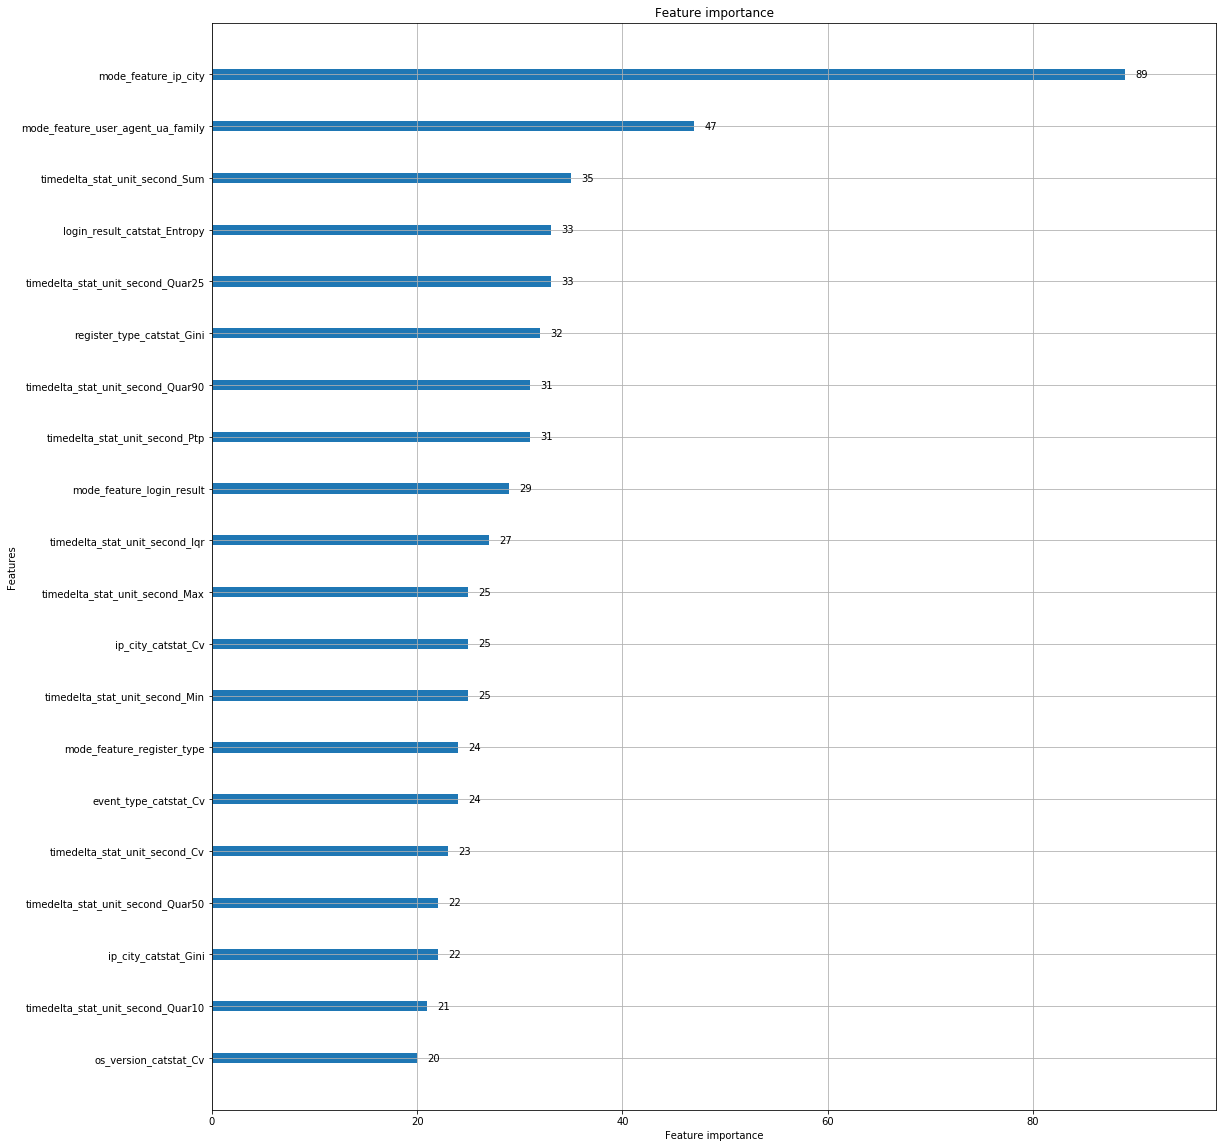

In [206]:
lgb.plot_importance(lgb_model, figsize=(18, 20), max_num_features=20)

In [207]:
params["n_estimators"] = lgb_model.best_iteration_ + 30 # todo 此处为什么要加30

In [208]:
lgb_model = lgb.LGBMClassifier(**params)

x_train_final = pdf_feature_all_train[feature_names]
y_train_final = pdf_feature_all_train["label"]

lgb_model.fit(x_train_final,
              y_train_final,
              eval_set = [(x_train_final, y_train_final)], 
              feature_name = feature_names)

[1]	training's auc: 0.760278
[2]	training's auc: 0.78492
[3]	training's auc: 0.802347
[4]	training's auc: 0.805073
[5]	training's auc: 0.81147
[6]	training's auc: 0.811963
[7]	training's auc: 0.814845
[8]	training's auc: 0.816361
[9]	training's auc: 0.816965
[10]	training's auc: 0.818273
[11]	training's auc: 0.820267
[12]	training's auc: 0.822112
[13]	training's auc: 0.823556
[14]	training's auc: 0.824895
[15]	training's auc: 0.825708
[16]	training's auc: 0.826444
[17]	training's auc: 0.827147
[18]	training's auc: 0.827992
[19]	training's auc: 0.829197
[20]	training's auc: 0.829811
[21]	training's auc: 0.830195
[22]	training's auc: 0.831096
[23]	training's auc: 0.831486
[24]	training's auc: 0.832081
[25]	training's auc: 0.832693
[26]	training's auc: 0.833028
[27]	training's auc: 0.833319
[28]	training's auc: 0.833828
[29]	training's auc: 0.834192
[30]	training's auc: 0.834626
[31]	training's auc: 0.834877
[32]	training's auc: 0.834987
[33]	training's auc: 0.835342
[34]	training's auc: 

LGBMClassifier(bagging_fraction=0.7, bagging_freq=2, boosting_type='gbdt',
        category_feature=['mode_feature_is_tech', 'mode_feature_is_recommend', 'mode_feature_os_version', 'mode_feature_checkout_status', 'mode_feature_user_agent_ua_family', 'mode_feature_status', 'mode_feature_bury', 'mode_feature_os_type', 'mode_feature_app_version', 'mode_feature_resource_type', 'mode_f...vice_family', 'mode_feature_category', 'mode_feature_event_type', 'mode_feature_resource_user_type'],
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
        importance_type='split', lambda_l1=0.25, lambda_l2=0.25,
        learning_rate=0.1, max_depth=4, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=170,
        n_jobs=32, num_leaves=31, objective='binary', random_state=2019,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [211]:
x_test = pdf_feature_all_test[feature_names]
y_test = pdf_feature_all_test["label"].astype("int")

x_test.shape, y_test.shape

((150640, 492), (150640,))

In [212]:
len([1 for x in y_test.tolist() if x==1])

1432

In [213]:
predict_result = lgb_model.predict_proba(x_test)

predict_result[:5]

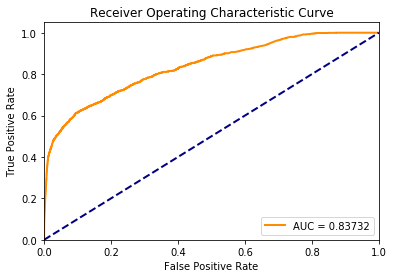

In [219]:
ClassificationEvaluate().roc(y_test.tolist(), [x[1] for x in predict_result])

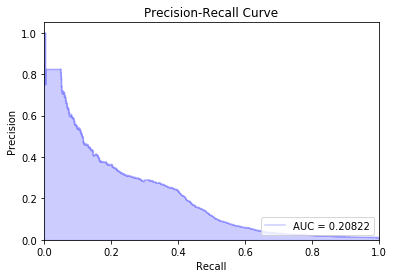

In [220]:
ClassificationEvaluate().precision_recall(y_test.tolist(), [x[1] for x in predict_result])

In [222]:
# top N 的准确率
label_score_tuple = zip(y_test.tolist(), [x[1] for x in predict_result])

N = 1000

tp = len([1 for x in sorted(label_score_tuple, key=lambda x: -x[1])[:N] if x[0]==1])
tp, 1.*tp/N

(326, 0.326)